In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import torch
torch.manual_seed(1)
import time
from config import get_arguments
from SinGAN.manipulate import *
from SinGAN.training import *
import SinGAN.functions as functions

General configuration(Please keep)

In [ ]:
INPUT_DIR = os.path.join(os.getcwd(), "input")
RANDOM_SEED = 1
GENERATION_START_SCALE = 0
OUTPUT_DIR = os.path.join(os.getcwd(), "output")
CHANNEL = 3 #SinGAN's Channel = 1 is having skimage.color.RGB2Gray and it seems there's some issue...fix it = 3

Model configuration

In [ ]:
for root, dirs, files in os.walk(os.path.join(os.getcwd(), "input")):
   for name in files:
      print(os.path.join(root, name))

In [ ]:
INPUT_NAME = "MNIST_0_input.png"
LAYER_NUMBER = 6 #5 layer * 3 scale is not quite okay for number 9
EPOCHS = 2000
#scale is automatically generated in functions.adjust_scales2image for now, as (the ceil of log of scale ratio) + 1
#maybe modified later (remove +1 or add additional +1)， still checking:
#MNIST: can use 6 layers * 3 scales for 5 layers * 4 scales
#CIFAR10:
SCALE_PLUS1 = True # default is True
ADDITIONAL_SCALE = False # default is False

In [ ]:
parser_train = get_arguments()
parser_train.add_argument('--input_dir')
parser_train.add_argument('--input_name')
parser_train.add_argument('--mode')
#newly added, have change in functions.adjust_scales2image --yihao
parser_train.add_argument('--scale_plus1', type=int, default = 1)
parser_train.add_argument('--additional_scale', type=int, default = 0)

opt_train = parser_train.parse_args(["--input_dir", INPUT_DIR, 
                                     "--input_name", INPUT_NAME, 
                                     "--manualSeed", str(RANDOM_SEED),
                                     "--mode", "train",
                                     "--out", OUTPUT_DIR,
                                     "--num_layer", str(LAYER_NUMBER),
                                     "--nc_z", str(CHANNEL),
                                     "--nc_im", str(CHANNEL),
                                     "--niter", str(EPOCHS),
                                     "--scale_plus1", str(int(SCALE_PLUS1)),
                                     "--additional_scale", str(int(ADDITIONAL_SCALE))
                                    ])
opt_train = functions.post_config(opt_train)

In [ ]:
Gs = []
Zs = []
reals = []
NoiseAmp = []
dir2save = functions.generate_dir2save(opt_train)#modified, the directory should be:
#f'{opt.out}/{opt.input_name}/layer={opt.num_layer}, iteration={opt.niter}, scale_factor={opt.scale_factor_init}, alpha={opt.alpha}'

In [ ]:
if (os.path.exists(dir2save)):
    print('layer={opt_train.num_layer}, iteration={opt_train.num_niter}, scale_factor={opt_train.scale_factor_init}, alpha={opt_train.alpha} model for {INPUT_NAME} already exist')
else:
    try:
        os.makedirs(dir2save)
    except OSError:
        pass

In [ ]:
start = time.time()
real = functions.read_image(opt_train)
functions.adjust_scales2image(real, opt_train)
train(opt_train, Gs, Zs, reals, NoiseAmp)
end = time.time()
print(f"traing time {end - start}s, for n_iter = {opt_train.niter}, layer_number = {opt_train.num_layer}")

6 layer * 3 scale ~ 740-780s
5 layer * 4 scale ~ 882s

In [ ]:
parser_generate = get_arguments()
parser_generate.add_argument('--input_dir', help='input image dir', default='Input/Images')
parser_generate.add_argument('--input_name', help='input image name', required=True)
parser_generate.add_argument('--mode', help='random_samples | random_samples_arbitrary_sizes', default='train', required=True)
# for random_samples:
parser_generate.add_argument('--gen_start_scale', type=int, help='generation start scale', default=0)
#newly added
parser_generate.add_argument('--scale_plus1', type=int, default=1)
parser_generate.add_argument('--additional_scale', type=int, default = 0)

opt_generate = parser_generate.parse_args(["--input_dir", INPUT_DIR, 
                                           "--input_name", INPUT_NAME, 
                                           "--mode", "random_samples",
                                           "--manualSeed", str(RANDOM_SEED),
                                           "--gen_start_scale", str(GENERATION_START_SCALE),
                                           "--out", OUTPUT_DIR,
                                           "--num_layer", str(LAYER_NUMBER),
                                           "--nc_z", str(CHANNEL),
                                           "--nc_im", str(CHANNEL),
                                           "--scale_plus1", str(int(SCALE_PLUS1)),
                                           "--additional_scale", str(int(ADDITIONAL_SCALE))
                                          ])
opt_generate = functions.post_config(opt_generate)

In [ ]:
Gs = []
Zs = []
reals = []
NoiseAmp = []
#dir2save = functions.generate_dir2save(opt) specified

In [ ]:
if dir2save is None:
    print('task does not exist')
else:
    real = functions.read_image(opt_generate)
    functions.adjust_scales2image(real, opt_generate)
    Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt_generate)
    in_s = functions.generate_in2coarsest(reals,1,1,opt_generate)
    current_output, list_output = SinGAN_generate(Gs, Zs, reals, NoiseAmp, opt_generate, gen_start_scale=opt_generate.gen_start_scale, output_image = True) #num_samples=50)
    # this function has a num_samples=50 as default

In [ ]:
plt.imshow(list_output[0])

In [10]:
def MNIST_generate_data(class_label = 0, generate_size = 50, random_seed = 1):
    INPUT_DIR = os.path.join(os.getcwd(), "input")
    RANDOM_SEED = random_seed
    GENERATION_START_SCALE = 0
    OUTPUT_DIR = os.path.join(os.getcwd(), "output")
    CHANNEL = 3 
    INPUT_NAME = f"MNIST_{class_label}_input_0.png"
    LAYER_NUMBER = 6
    SCALE_PLUS1 = True
    ADDITIONAL_SCALE = False
    parser_generate = get_arguments()
    parser_generate.add_argument('--input_dir')
    parser_generate.add_argument('--input_name')
    parser_generate.add_argument('--mode')
    parser_generate.add_argument('--gen_start_scale', type=int)
    parser_generate.add_argument('--scale_plus1', type=int)
    parser_generate.add_argument('--additional_scale', type=int)

    opt_generate = parser_generate.parse_args(["--input_dir", INPUT_DIR, 
                                               "--input_name", INPUT_NAME, 
                                               "--mode", "random_samples",
                                               "--manualSeed", str(RANDOM_SEED),
                                               "--gen_start_scale", str(GENERATION_START_SCALE),
                                               "--out", OUTPUT_DIR,
                                               "--num_layer", str(LAYER_NUMBER),
                                               "--nc_z", str(CHANNEL),
                                               "--nc_im", str(CHANNEL),
                                               "--scale_plus1", str(int(SCALE_PLUS1)),
                                               "--additional_scale", str(int(ADDITIONAL_SCALE))
                                              ])
    
    opt_generate = functions.post_config(opt_generate)
    Gs = []
    Zs = []
    reals = []
    NoiseAmp = []
    dir2save = functions.generate_dir2save(opt_generate)
    if dir2save is None:
        return 'task does not exist'
    else:
        real = functions.read_image(opt_generate)
        functions.adjust_scales2image(real, opt_generate)
        Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt_generate)
        in_s = functions.generate_in2coarsest(reals,1,1,opt_generate)
        current_output, list_output = SinGAN_generate(Gs, Zs, reals, NoiseAmp, opt_generate, 
                                                      gen_start_scale=opt_generate.gen_start_scale, 
                                                      output_image = False, 
                                                      num_samples = generate_size)
        return list_output

Random Seed:  1


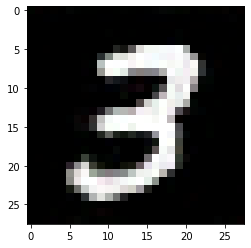

In [11]:
a = MNIST_generate_data(class_label = 3, generate_size = 150)
plt.imshow(a[random.randint(0,150)])

In [2]:
def MNIST_train_model(input_name, layer_number = 6, random_seed = 1, epochs = 2000, Scale_plus1 = True, additional_scale = False):
    INPUT_DIR = os.path.join(os.getcwd(), "input")
    OUTPUT_DIR = os.path.join(os.getcwd(), "output")
    RANDOM_SEED = random_seed
    CHANNEL = 3
    INPUT_NAME = input_name
    LAYER_NUMBER = layer_number #5 layer * 3 scale is not quite okay for number 9
    EPOCHS = epochs
    SCALE_PLUS1 = Scale_plus1
    ADDITIONAL_SCALE = additional_scale
    GENERATION_START_SCALE = 0
    parser_train = get_arguments()
    parser_train.add_argument('--input_dir')
    parser_train.add_argument('--input_name')
    parser_train.add_argument('--mode')
    #newly added, have change in functions.adjust_scales2image --yihao
    parser_train.add_argument('--scale_plus1', type=int, default = 1)
    parser_train.add_argument('--additional_scale', type=int, default = 0)
    parser_train.add_argument("--gen_start_scale", type=int)

    opt_train = parser_train.parse_args(["--input_dir", INPUT_DIR, 
                                         "--input_name", INPUT_NAME, 
                                         "--mode", "train",
                                         "--manualSeed", str(RANDOM_SEED),
                                         "--out", OUTPUT_DIR,
                                         "--gen_start_scale", str(GENERATION_START_SCALE),
                                         "--num_layer", str(LAYER_NUMBER),
                                         "--nc_z", str(CHANNEL),
                                         "--nc_im", str(CHANNEL),
                                         "--niter", str(EPOCHS),
                                         "--scale_plus1", str(int(SCALE_PLUS1)),
                                         "--additional_scale", str(int(ADDITIONAL_SCALE))
                                        ])
    opt_train = functions.post_config(opt_train)
    Gs = []
    Zs = []
    reals = []
    NoiseAmp = []
    dir2save = functions.generate_dir2save(opt_train)
    if (os.path.exists(dir2save)):
        print('layer={opt_train.num_layer}, iteration={opt_train.num_niter}, scale_factor={opt_train.scale_factor_init}, alpha={opt_train.alpha} model for {INPUT_NAME} already exist')
    else:
        try:
            os.makedirs(dir2save)
        except OSError:
            pass
    start = time.time()
    real = functions.read_image(opt_train)
    functions.adjust_scales2image(real, opt_train)
    train(opt_train, Gs, Zs, reals, NoiseAmp)
    end = time.time()
    print(f"traing time {end - start}s, for n_iter = {opt_train.niter}, layer_number = {opt_train.num_layer}")
    SinGAN_generate(Gs, Zs, reals, NoiseAmp, 
                    opt_train, 
                    gen_start_scale=opt_train.gen_start_scale, 
                    output_image = True)

In [ ]:
#for i in range(3,9):
i = 4
for j in range(5,20):
    MNIST_train_model(f"MNIST_{i}_input_{j}.png")

Random Seed:  1
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [27]:
def MNIST_generate_data(class_label = 9, generate_size = 50, random_seed = 1, sample_size = 5):
    INPUT_DIR = os.path.join(os.getcwd(), "input")
    RANDOM_SEED = random_seed
    GENERATION_START_SCALE = 0
    OUTPUT_DIR = os.path.join(os.getcwd(), "output")
    CHANNEL = 3 
    INPUT_NAME = [f"MNIST_{class_label}_input_{i}.png" for i in range(sample_size)]
    LAYER_NUMBER = 6
    SCALE_PLUS1 = True
    ADDITIONAL_SCALE = False
    output = []
    parser_generate = get_arguments()
    parser_generate.add_argument('--input_dir')
    parser_generate.add_argument('--input_name')
    parser_generate.add_argument('--mode')
    parser_generate.add_argument('--gen_start_scale', type=int)
    parser_generate.add_argument('--scale_plus1', type=int)
    parser_generate.add_argument('--additional_scale', type=int)
    for i in range(sample_size):
        opt_generate = parser_generate.parse_args(["--input_dir", INPUT_DIR, 
                                                   "--input_name", INPUT_NAME[i], 
                                                   "--mode", "random_samples",
                                                   "--manualSeed", str(RANDOM_SEED),
                                                   "--gen_start_scale", str(GENERATION_START_SCALE),
                                                   "--out", OUTPUT_DIR,
                                                   "--num_layer", str(LAYER_NUMBER),
                                                   "--nc_z", str(CHANNEL),
                                                   "--nc_im", str(CHANNEL),
                                                   "--scale_plus1", str(int(SCALE_PLUS1)),
                                                   "--additional_scale", str(int(ADDITIONAL_SCALE))
                                                  ])
        opt_generate = functions.post_config(opt_generate)
        print(opt_generate.input_name)
        Gs = []
        Zs = []
        reals = []
        NoiseAmp = []
        dir2save = functions.generate_dir2save(opt_generate)
        print(dir2save)
        if dir2save is None:
            return 'task does not exist'
        else:
            real = functions.read_image(opt_generate)
            functions.adjust_scales2image(real, opt_generate)
            Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt_generate)
            in_s = functions.generate_in2coarsest(reals,1,1,opt_generate)
            current_output, list_output = SinGAN_generate(Gs, Zs, reals, NoiseAmp, opt_generate, 
                                                          gen_start_scale=opt_generate.gen_start_scale, 
                                                          output_image = False, 
                                                          num_samples = int(generate_size/sample_size))
            output += list_output
    return output

In [29]:
a = MNIST_generate_data(class_label = 9, generate_size = 50)

Random Seed:  1
MNIST_9_input_0.png
/home/jupyter/output/MNIST_9_input_0.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_9_input_1.png
/home/jupyter/output/MNIST_9_input_1.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_9_input_2.png
/home/jupyter/output/MNIST_9_input_2.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_9_input_3.png
/home/jupyter/output/MNIST_9_input_3.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_9_input_4.png
/home/jupyter/output/MNIST_9_input_4.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10


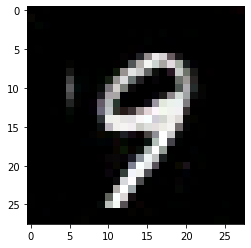

In [34]:
plt.imshow(a[41])